# Time series regression - Store sales forecasting, Part 1

Ahmet Zamanis

## Introduction

This is a report on time series analysis & regression modeling,
performed in Python, mainly with the
[Darts](https://unit8co.github.io/darts/) library. The dataset is from
the [Kaggle Store Sales - Time Series
Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)
competition. The data consists of daily sales data for an Ecuadorian
supermarket chain between 2013 and 2017. This is Part 1 of the analysis,
which will focus only on forecasting the daily national sales of the
chain, across all stores and categories. In Part 2, I will forecast the
sales in each category - store combination as required by the
competition, and attempt various hierarchical reconciliation techniques.

The main information source used extensively for this analysis is the
textbook [Forecasting: Principles and
Practice](https://otexts.com/fpp3/), written by Rob Hyndman and George
Athanasopoulos. The book is the most complete source on time series
analysis & forecasting I could find. It uses R and the
[tidyverts](https://tidyverts.org/) libraries in its example code.

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set printing options
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Set plotting options
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.autolayout"] = True
sns.set_theme(context="paper")

## Data preparation

The data is split into several .csv files.

**.csv** and **test.csv** are the main datasets, consisting of daily
sales data. The ing data ranges from 01-01-2013 to 15-08-2017, and the
testing data consists of the next 15 days, in August 2017. We won’t do a
competition submission in Part 1, so we won’t load the testing data.

In [3]:
# View the daily sales data
df_train.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0000,0
1,1,2013-01-01,1,BABY CARE,0.0000,0
2,2,2013-01-01,1,BEAUTY,0.0000,0
3,3,2013-01-01,1,BEVERAGES,0.0000,0
4,4,2013-01-01,1,BOOKS,0.0000,0


-   For each day, we have the sales in each store (out of a possible 54)
    and each product category (out of a possible 33). This amounts to
    1782 time series that need to be forecasted for the competition, but
    in Part 1 of this analysis, we will keep it simple and only forecast
    the national sales in each day, in all categories.

-   **onpromotion** is the number of items on sale that day, in that
    category & store.

**stores.csv** contains more information about each store: The city,
state, store type and store cluster.

In [4]:
# View the stores data
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**holidays.csv** contains information about local (city-wide), regional
(state-wide) and national holidays, as well as some special nation-wide
events in the time period. We will use these along with the stores’
location data to create calendar features.

In [5]:
# View the holidays data
df_holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


**oil.csv** consists of the daily oil prices in the time period. Ecuador
has an oil-dependent economy, so this may be a useful predictor of the
cyclicality in supermarket sales.

In [6]:
# View the oil data
df_oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.1400
2,2013-01-03,92.9700
3,2013-01-04,93.1200
4,2013-01-07,93.2000


**transactions.csv** consists of the daily number of transactions in a
store. Another potentially useful feature.

In [7]:
df_trans.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


We will rename some columns from the datasets and merge the
supplementary information into the ing data. We’ll aggregate daily
transactions across all stores beforehand, as we are only interested in
predicting daily national sales.

In [8]:
# Rename columns
df_holidays = df_holidays.rename(columns = {"type":"holiday_type"})
df_oil = df_oil.rename(columns = {"dcoilwtico":"oil"})
df_stores = df_stores.rename(columns = {
  "type":"store_type", "cluster":"store_cluster"})

# Aggregate daily transactions across all stores
df_trans = df_trans.groupby("date").transactions.sum()

# Add columns from oil, stores and transactions datasets into main data
df_train = df_train.merge(df_trans, on = ["date"], how = "left")
df_train = df_train.merge(df_oil, on = "date", how = "left")
df_train = df_train.merge(df_stores, on = "store_nbr", how = "left")

Incorporating the holidays information into the sales dataset will
require more work.

In [9]:
# Split holidays data into local, regional, national and events
events = df_holidays[df_holidays["holiday_type"] == "Event"]
df_holidays = df_holidays.drop(labels=(events.index), axis=0)
local = df_holidays.loc[df_holidays["locale"] == "Local"]
regional = df_holidays.loc[df_holidays["locale"] == "Regional"]
national = df_holidays.loc[df_holidays["locale"] == "National"]

There are cases of multiple holidays or events sharing the same date and
locale. We’ll inspect the duplicates and drop them, so we don’t have
issues in feature engineering.

-   Rows with **transferred = True** are dates that are normally
    holidays, but the holiday was transferred to another day. In other
    words, these are not holidays in effect.

-   Rows with **holiday_type = Transfer** are dates that are not
    normally holidays, but had another holiday transferred. In other
    words, these are holidays in effect.

-   Rows with **holiday_type = Bridge** are dates that are not normally
    holidays, but were added to preceding / following holidays.

In [10]:
# Inspect local holidays sharing same date & locale. Drop the transfer row
local[local.duplicated(["date", "locale_name"], keep = False)]
local = local.drop(265, axis = 0)

In [11]:
# Inspect regional holidays sharing same date & locale. None exist
regional[regional.duplicated(["date", "locale_name"], keep = False)]

,date,holiday_type,locale,locale_name,description,transferred


In [12]:
# Inspect national holidays sharing same date & locale. Drop bridge days
national[national.duplicated(["date"], keep = False)]
national = national.drop([35, 39, 156], axis = 0)

In [13]:
# Inspect events sharing same date. Drop the earthquake row as it is a one-time event
events[events.duplicated(["date"], keep = False)]
events = events.drop(244, axis = 0)

After getting rid of duplicates, we can create binary columns that
signify whether a date was a local / regional / national holiday /
event. We’ll merge these back into the sales data.

We’ll set the **date** column to a DateTimeIndex, and view the sales
data with the added columns.

In [15]:
# Set datetime index
df_train = df_train.set_index(pd.to_datetime(df_train.date))
df_train = df_train.drop("date", axis=1)
df_train.head(5)

,id,store_nbr,family,sales,onpromotion,transactions,oil,city,state,store_type,store_cluster,local_holiday,regional_holiday,national_holiday,event
date,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0000,0,770.0000,NaN,Quito,Pichincha,D,13,0,0,1,0
2013-01-01,1,1,BABY CARE,0.0000,0,770.0000,NaN,Quito,Pichincha,D,13,0,0,1,0
2013-01-01,2,1,BEAUTY,0.0000,0,770.0000,NaN,Quito,Pichincha,D,13,0,0,1,0
2013-01-01,3,1,BEVERAGES,0.0000,0,770.0000,NaN,Quito,Pichincha,D,13,0,0,1,0
2013-01-01,4,1,BOOKS,0.0000,0,770.0000,NaN,Quito,Pichincha,D,13,0,0,1,0


With financial data, it’s a good idea to normalize for inflation. We’ll
CPI adjust the sales and oil prices columns, with 2010 as our base year.
The CPI values for Ecuador in the time period were retrieved
[here](https://data.worldbank.org/indicator/FP.CPI.TOTL?end=2017&locations=EC&start=2010&view=chart).

-   We’ll use the yearly CPI values for simplicity’s sake, but it’s
    possible to use monthly CPI for more accuracy.

-   Since 2017 is not complete in the data, and we’ll use it as the
    validation-testing period, we’ll use 2016’s CPI for 2017 to avoid
    leaking information from the future into our predictions.

We have some rows with missing values in our training data.

In [17]:
# Check missing values in each column
pd.isnull(df_train).sum()

id                       0
store_nbr                0
family                   0
sales                    0
onpromotion              0
transactions          3564
oil                 928422
city                     0
state                    0
store_type               0
store_cluster            0
local_holiday            0
regional_holiday         0
national_holiday         0
event                    0
dtype: int64

We will interpolate the missing values in the oil and transactions
columns using time interpolation. This performs linear interpolation,
but also takes the date-time index of observations into account.

In [18]:
df_train["oil"] = df_train["oil"].interpolate("time", limit_direction = "both")
df_train["transactions"] = df_train["transactions"].interpolate("time", limit_direction = "both")

We will now aggregate daily sales across all categories and stores, to
retrieve our target variable.

In [19]:
sales = df_train.groupby("date").sales.sum()
sales

date
2013-01-01     2226.6126
2013-01-02   439798.2429
2013-01-03   320444.3538
2013-01-04   314237.3024
2013-01-05   423182.7316
                 ...    
2017-08-11   668587.1537
2017-08-12   641286.8407
2017-08-13   700355.7261
2017-08-14   615633.0146
2017-08-15   617040.4012
Name: sales, Length: 1684, dtype: float64

We will create a Darts TimeSeries with our target variable.

In [20]:
from darts import TimeSeries
ts_sales = TimeSeries.from_series(sales, freq="D")
ts_sales

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[ 2226.6126]],

 [[439798.2429]],

 [[320444.3538]],

 ...,

 [[700355.7261]],

 [[615633.0146]],

 [[617040.4012]]])
Coordinates:
 * date (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
 * component (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
 static_covariates: None
 hierarchy: None TimeSeries (DataArray) date : 1688 component : 1 sample : 1 2.227e+03 4.398e+05 3.204e+05 ... 7.004e+05 6.156e+05 6.17e+05 array([[[ 2226.6126]],

 [[439798.2429]],

 [[320444.3538]],

 ...,

 [[700355.7261]],

 [[615633.0146]],

 [[617040.4012]]]) Coordinates: (2) date (date) datetime64[ns] 2013-01-01 ... 2017-08-15 array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
 '2013-01-03T00:00:00.000000000', ..., '2017-08-13T00:00:00.000000000',
 '2017-08-14T00:00:00.000000000', '2017-08-15T00:00:00.000000000'],
 dtype='datetime64[ns]') component (component) object 'sales' array(['sales'], dtype=object) Indexes: (2) date PandasIndex PandasIndex(DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
 '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
 '2013-01-09', '2013-01-10',
 ...
 '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
 '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
 '2017-08-14', '2017-08-15'],
 dtype='datetime64[ns]', name='date', length=1688, freq='D')) component PandasIndex PandasIndex(Index(['sales'], dtype='object', name='component')) Attributes: (2) static_covariates : None hierarchy : None

-   Each Pandas series / dataframe column passed is stored as a
    component in the Darts TS. The date-time index is stored in
    **time_index.**

-   To create a multivariate time series from a Pandas dataframe, we
    create a dataframe with each time series as a column, and a common
    date-time index. If the time series have a **hierarchy**, i.e. if
    they sum up together in a certain way, we can map that hierarchy as
    a dictionary. We will explore this further in part 2 of the
    analysis.

-   Static covariates are time-invariant covariates that may be used in
    predictions. In our case, the city or cluster of a store may be
    static covariates, but for part 1 of our analysis, we won’t use
    these.

## Overview of hybrid modeling approach

A time series can be written as the sum of several components:

-   **Trend:** The long-term change.

-   **Seasonality:** A fluctuation that repeats based on a fixed, known
    time period. For example, the effect of month / season on ice cream
    sales.

-   **Cyclicality:** A fluctuation that does not repeat on a fixed,
    known time period. For example, the effect of oil prices on car
    sales.

-   **Remainder / Error:** The unpredictable component of the time
    series, at least with the available data.

When analyzing a time series with plots, it can be difficult to
determine the sources of changes and fluctuations. It can be especially
tricky to tell apart the cyclical effects from seasonality. Because of
this, we will split our analysis and modeling into two steps:

-   In step 1, we will analyze the effects of trend, seasonality and
    calendar effects (such as holidays & events), build a model that
    predicts these effects and removes them from the series. This is
    called **time decomposition.**

-   In step 2, we will re-analyze the decomposed time series, this time
    considering the effects of covariates and lagged values of sales
    itself as predictors. We’ll build a model that uses these
    predictors, train it on the decomposed sales, and add up the
    predictions of both models to arrive at our final predictions. This
    approach is called a **hybrid model.**

## Exploratory analysis 1 - Time & calendar effects

### Trend

Let’s start by analyzing the overall trend in sales. Darts offers the
ability to plot time series quickly.

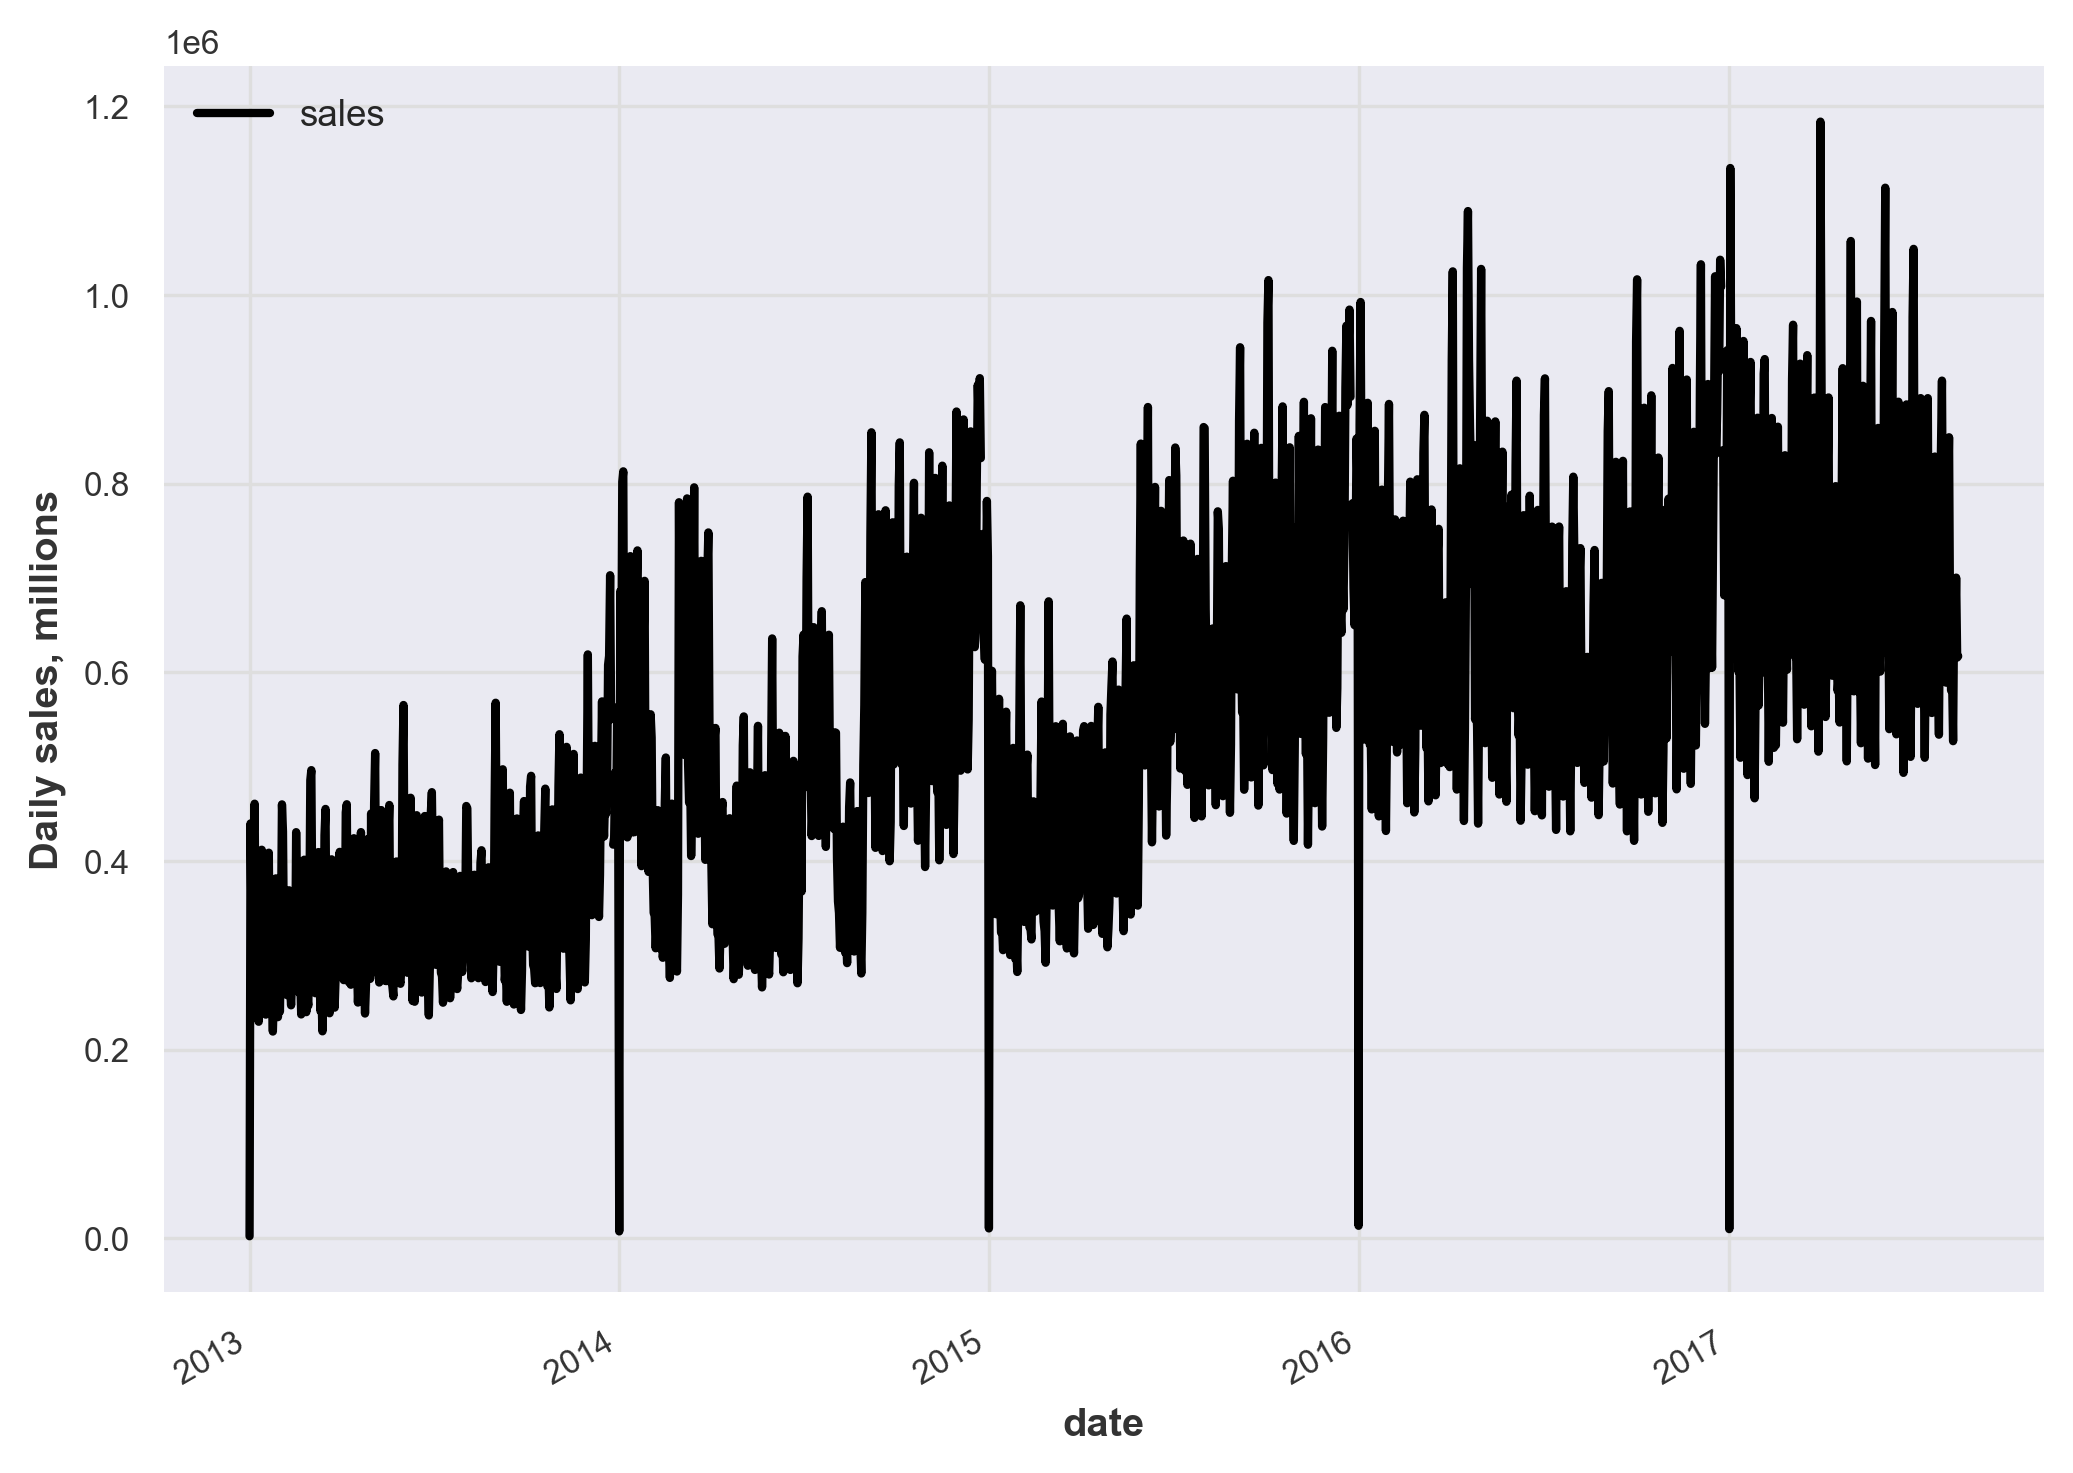

In [21]:
_ =  ts_sales.plot()
_ =  plt.ylabel("Daily sales, millions")
plt.show()
plt.close()

The series plot shows us several things:

-   Supermarket sales show an increasing trend over the years. The trend
    is close to linear overall, but the rate of increase declines
    roughly from the start of 2015.

-   Sales mostly fluctuate around a certain range, which suggests strong
    seasonality. However, there are also sharp deviations in certain
    periods, mainly across 2014 and at the start of 2015. This is likely
    cyclical in nature.

-   Sales decline very sharply in the first day of every year.

### Seasonality

#### Annual

Let’s look at annual seasonality: How sales fluctuate over a year based
on quarters, months, weeks of a year and days of a year. In the plots
below, we have the daily sales averaged by each respective calendar
period, colored by each year in the data. The confidence bands indicate
the minimum and maximum daily sales in each respective period (in the
last plot, we just have the daily sales without any averaging).

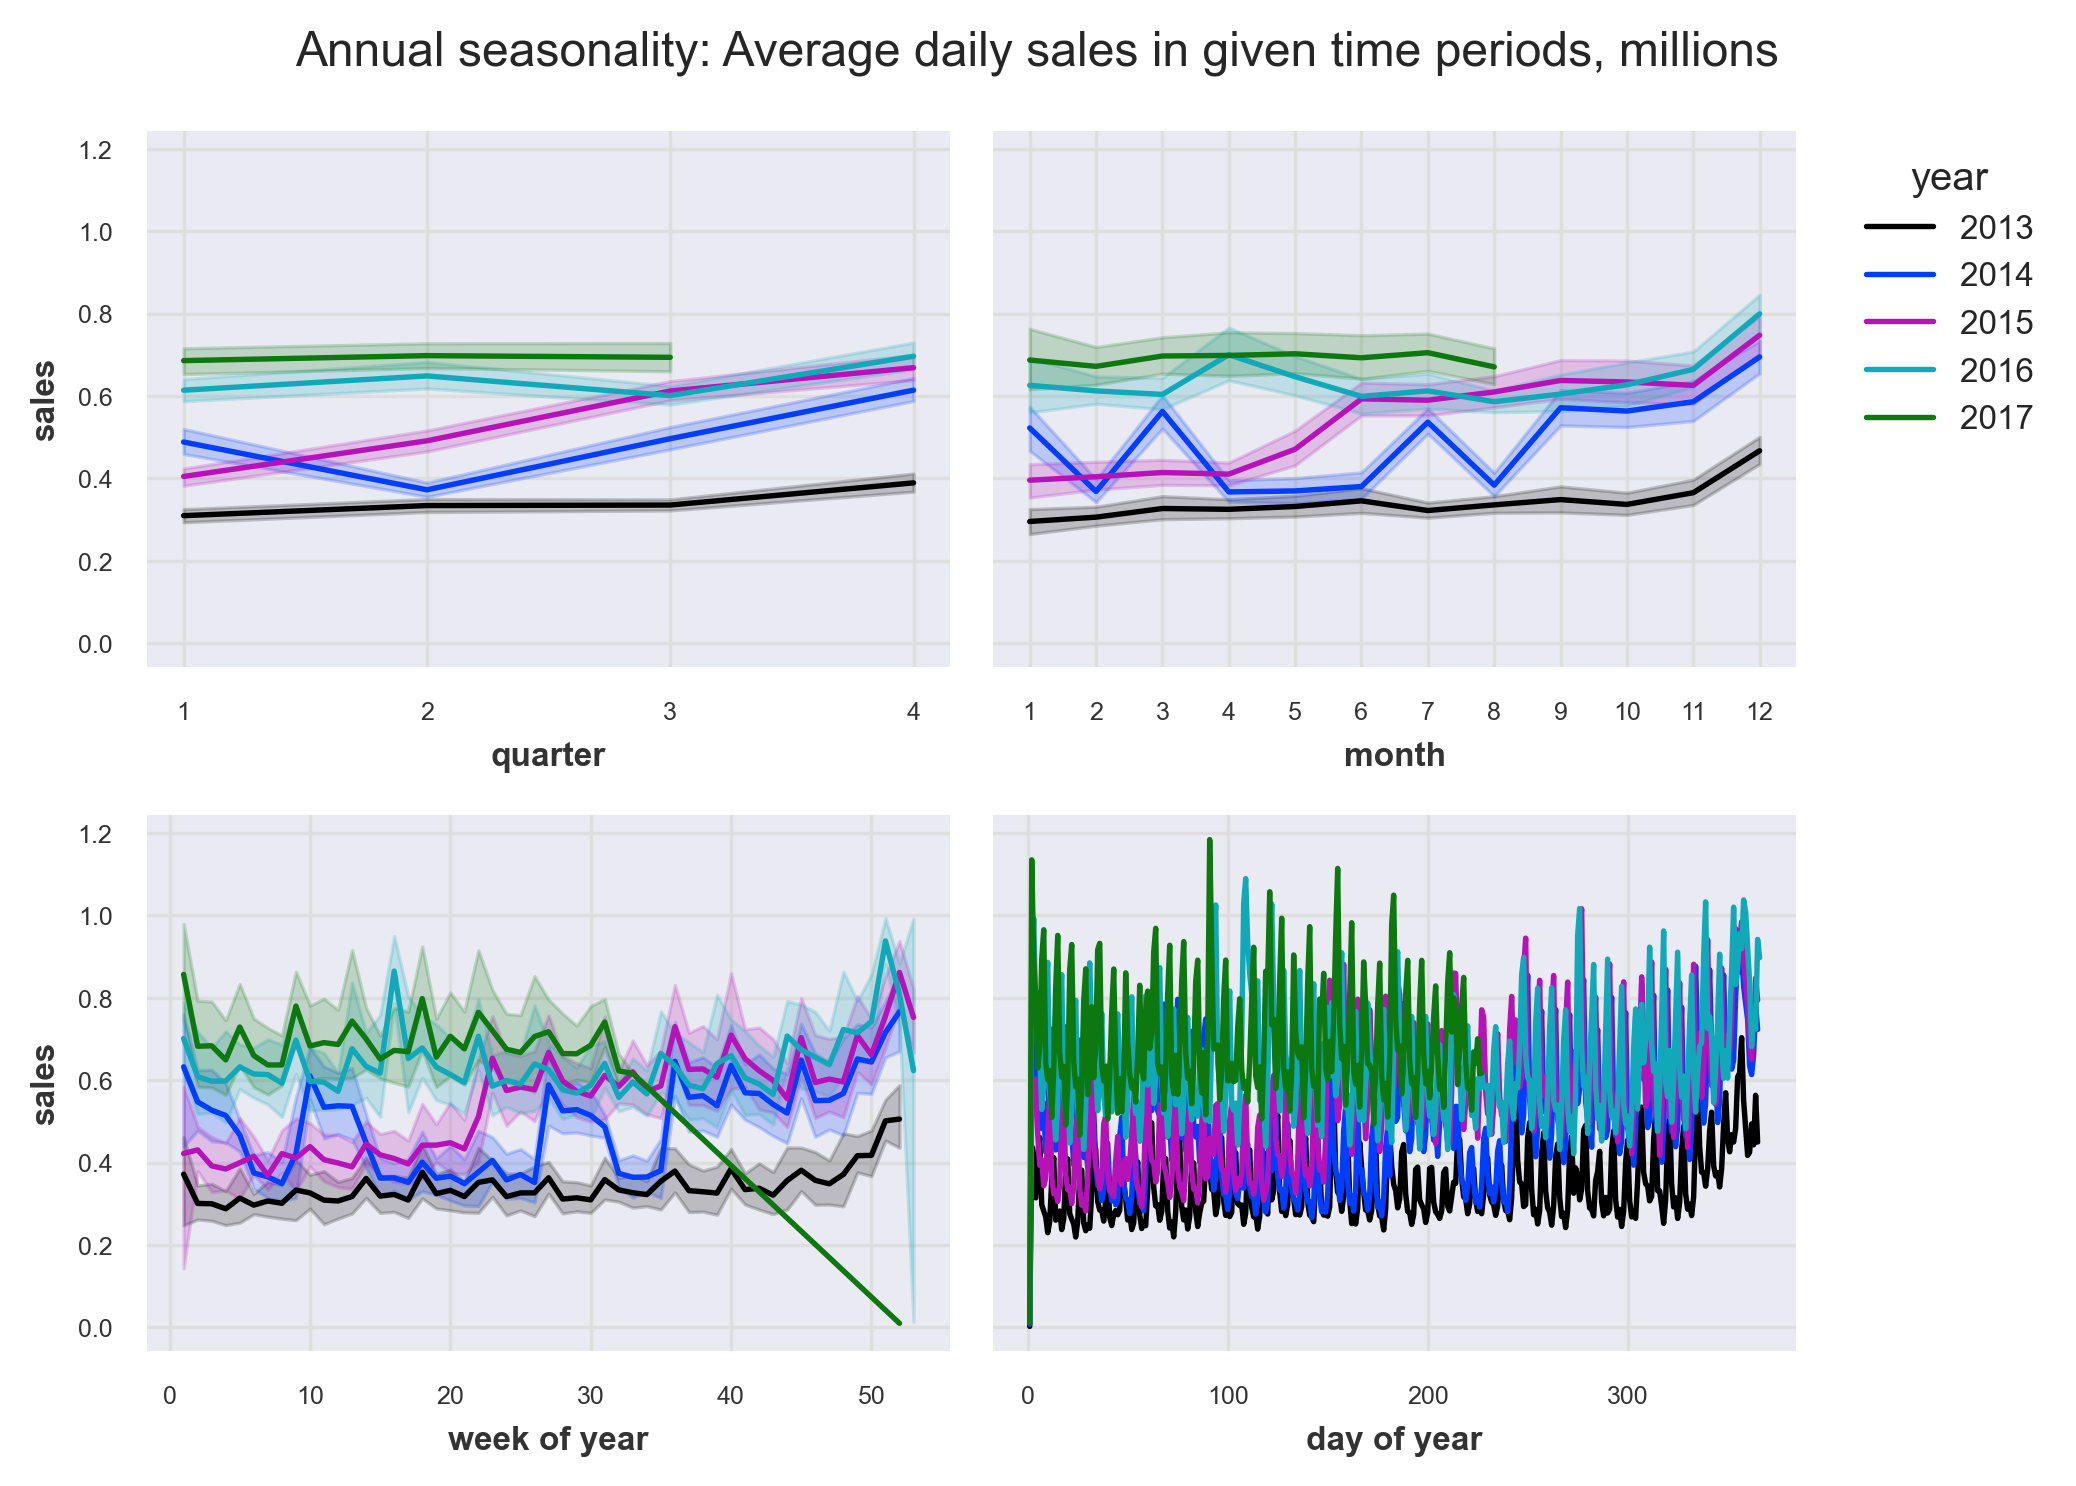

-   **Quarterly:** Sales do not seem to have a considerable quarterly
    seasonality pattern. However, the plot still shows us a few things:

    -   Sales generally slightly increase over a year.

    -   In Q2 2014, there was a considerable drop. Sales declined almost
        to the level of Q2 2013. This was likely a cyclical effect.

-   **Monthly:** Sales do seem to fluctuate slightly over months, but
    there’s no clear seasonal pattern that holds across all years.
    However, sales seem to sharply increase in December every year,
    likely due to Christmas.

<!-- -->

    -   The cyclicality in 2014 is seen in more detail: Sales dropped almost to their 2013 levels in certain months, and recovered sharply in others.

    -   We also see a considerable drop in the first half of 2015, where sales dropped roughly to 2014 levels, followed by a recovery.

    -   There is a very sharp increase in April 2016, where sales were even higher than 2017 levels. This is due to a large earthquake that happened in April 16, 2016, and the related relief efforts.

-   **Weekly:** The seasonal patterns are more visible in the weekly
    plot, as we see the “waves” line up across years. It’s very likely
    the data has strong weekly seasonality, which is what we’d expect
    from supermarket sales.

    -   The data for 2017 ends after August 15, so the sharp decline
        afterwards is misleading.

    -   The decline at the end of 2016 is also misleading, as 2016 was a
        366-day year.

-   **Daily:** This plot is a bit noisy, but the very similar
    fluctuations across all years indicate the data is strongly
    seasonal. It also highlights some cyclical effects such as the April
    2016 earthquake and the 2014 drops.

Another way to look at annual seasonality is to average sales in a
certain calendar period across all years, without grouping by year. This
shows us the “overall” seasonality pattern across one year: We likely
have strong weekly seasonality that persists over years, and some
monthly seasonality especially towards December.

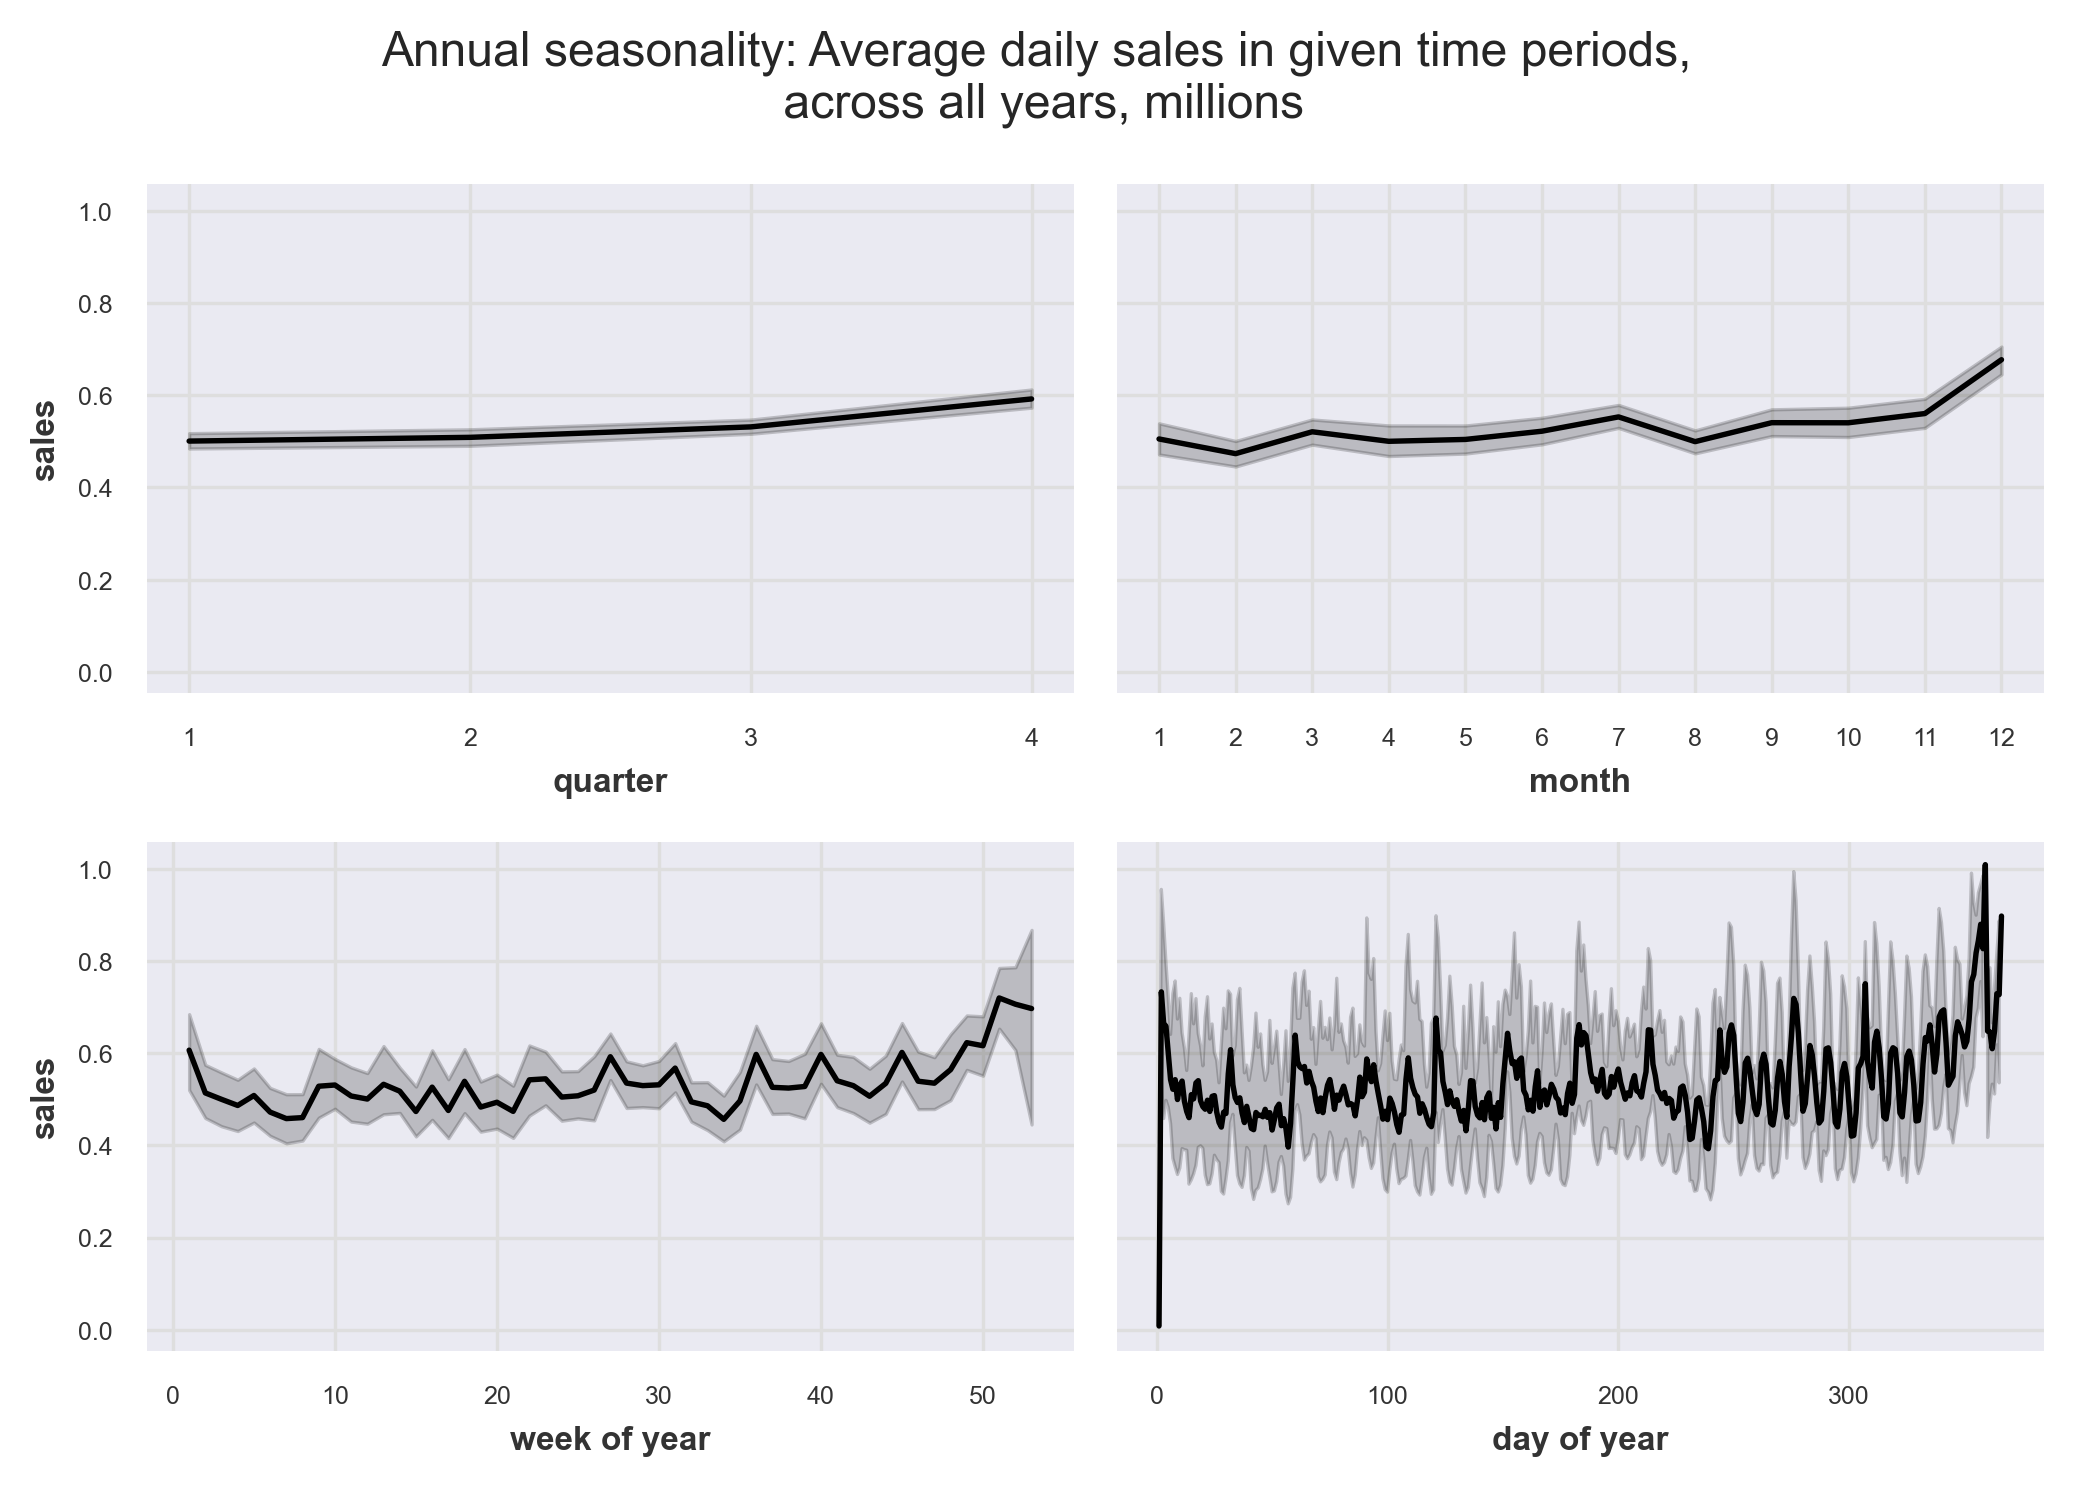

#### Monthly & weekly

Now let’s look at seasonality across days of a month and days of a week.
These will likely be the most important seasonality patterns in the
sales. There are three ways to look at these plots: First we will group
them by year.

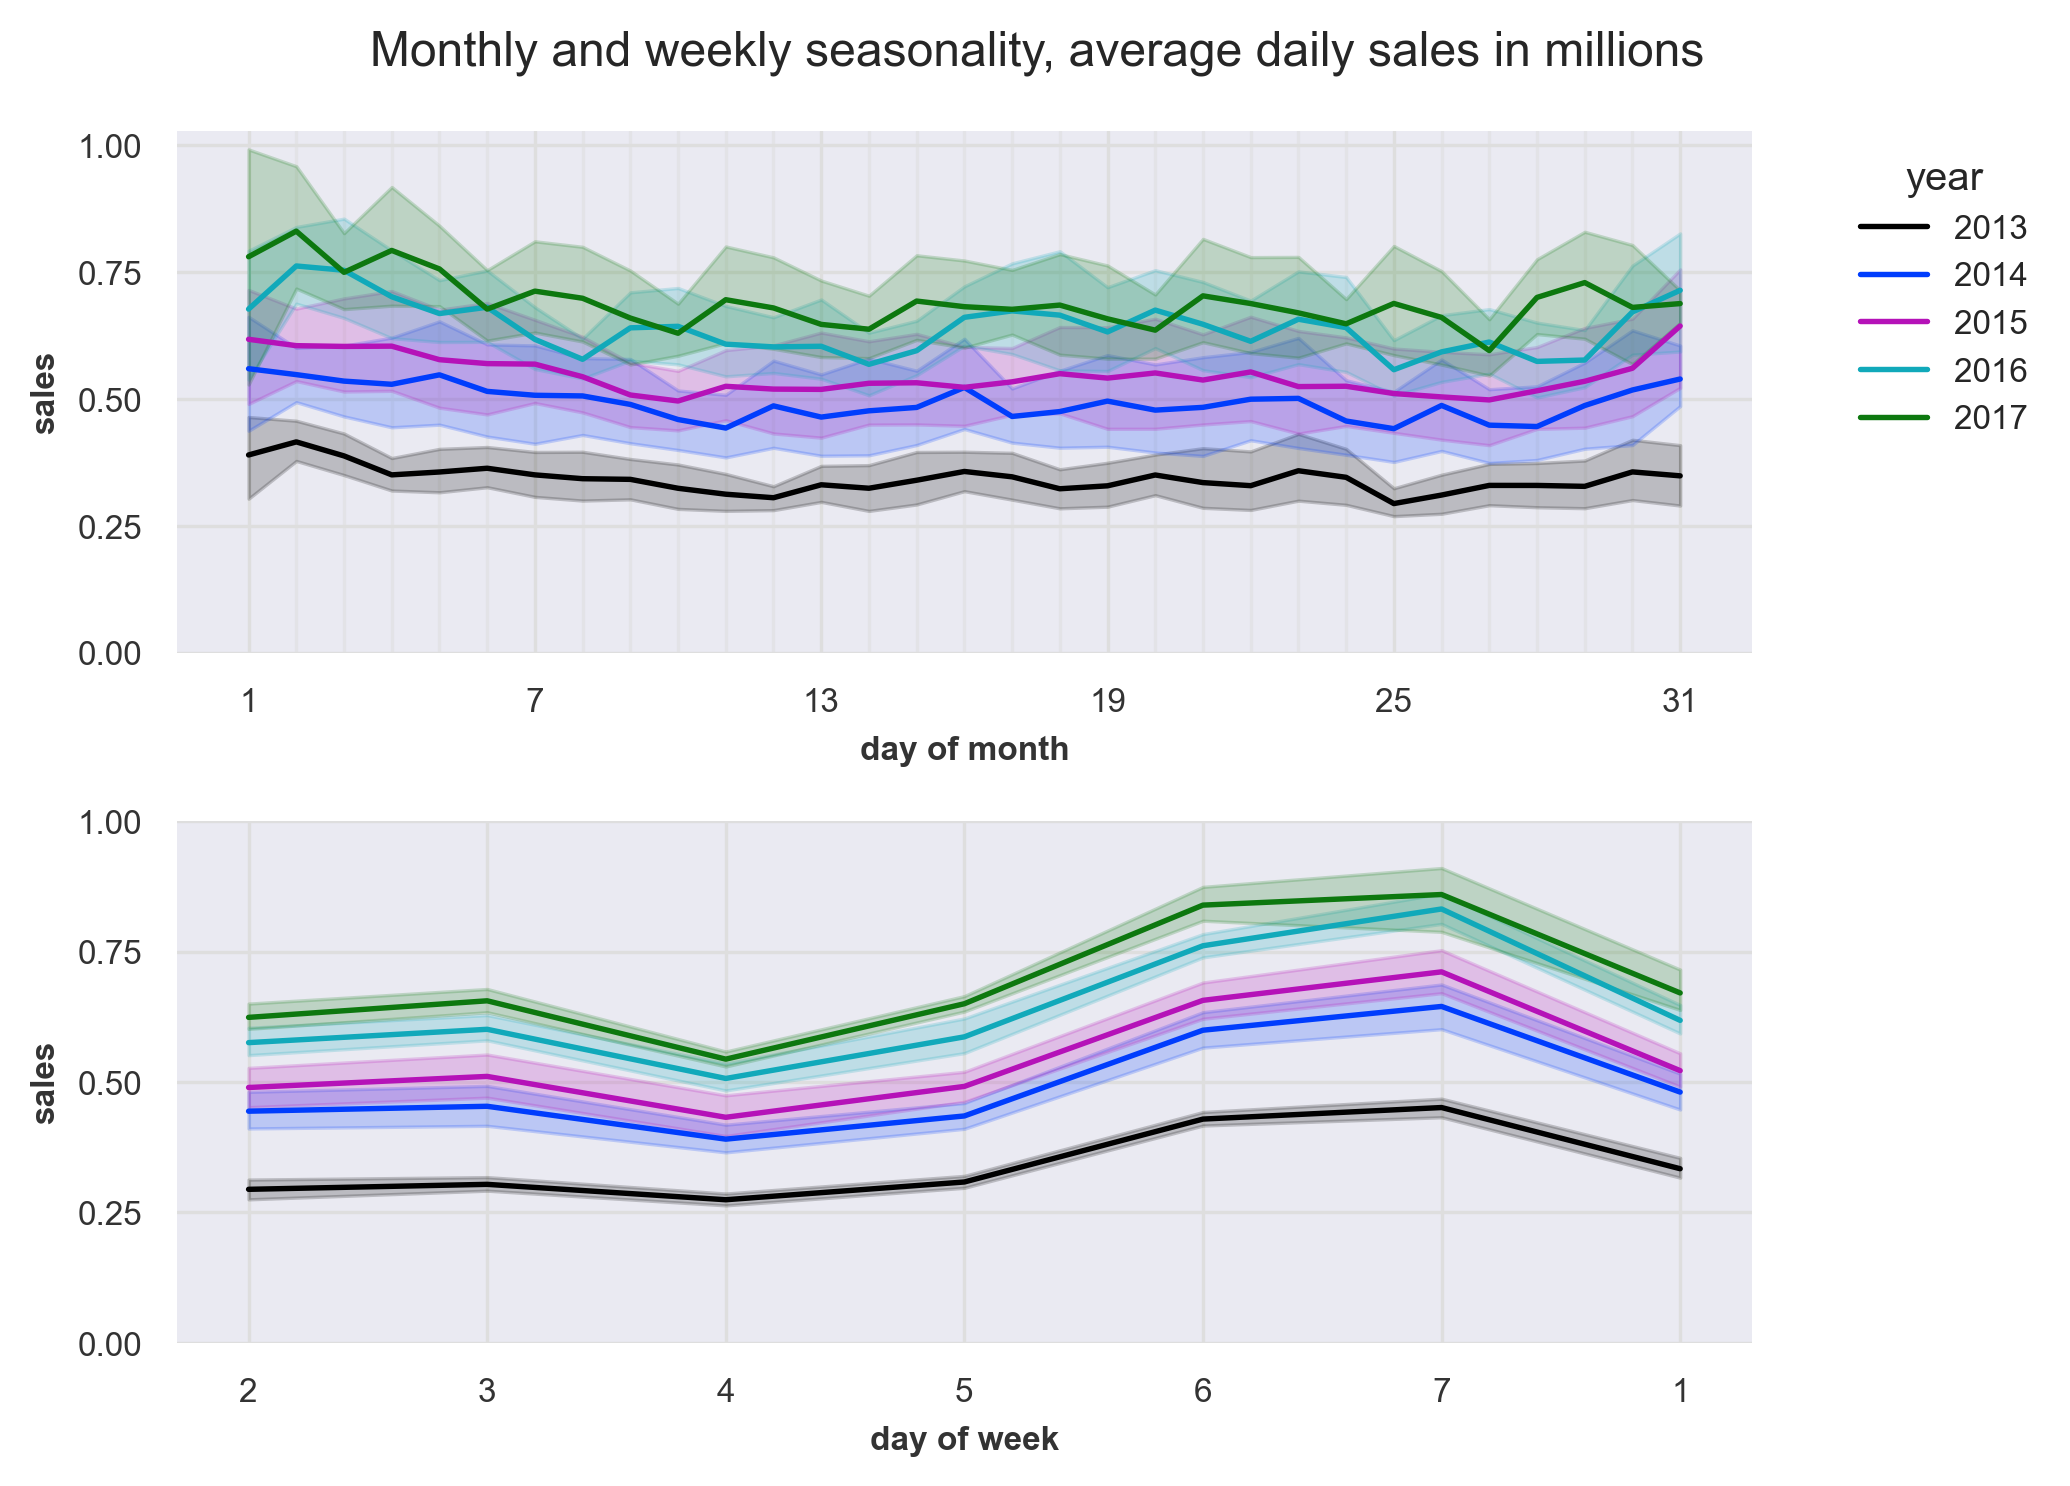

We can look at the same plots grouped by month.

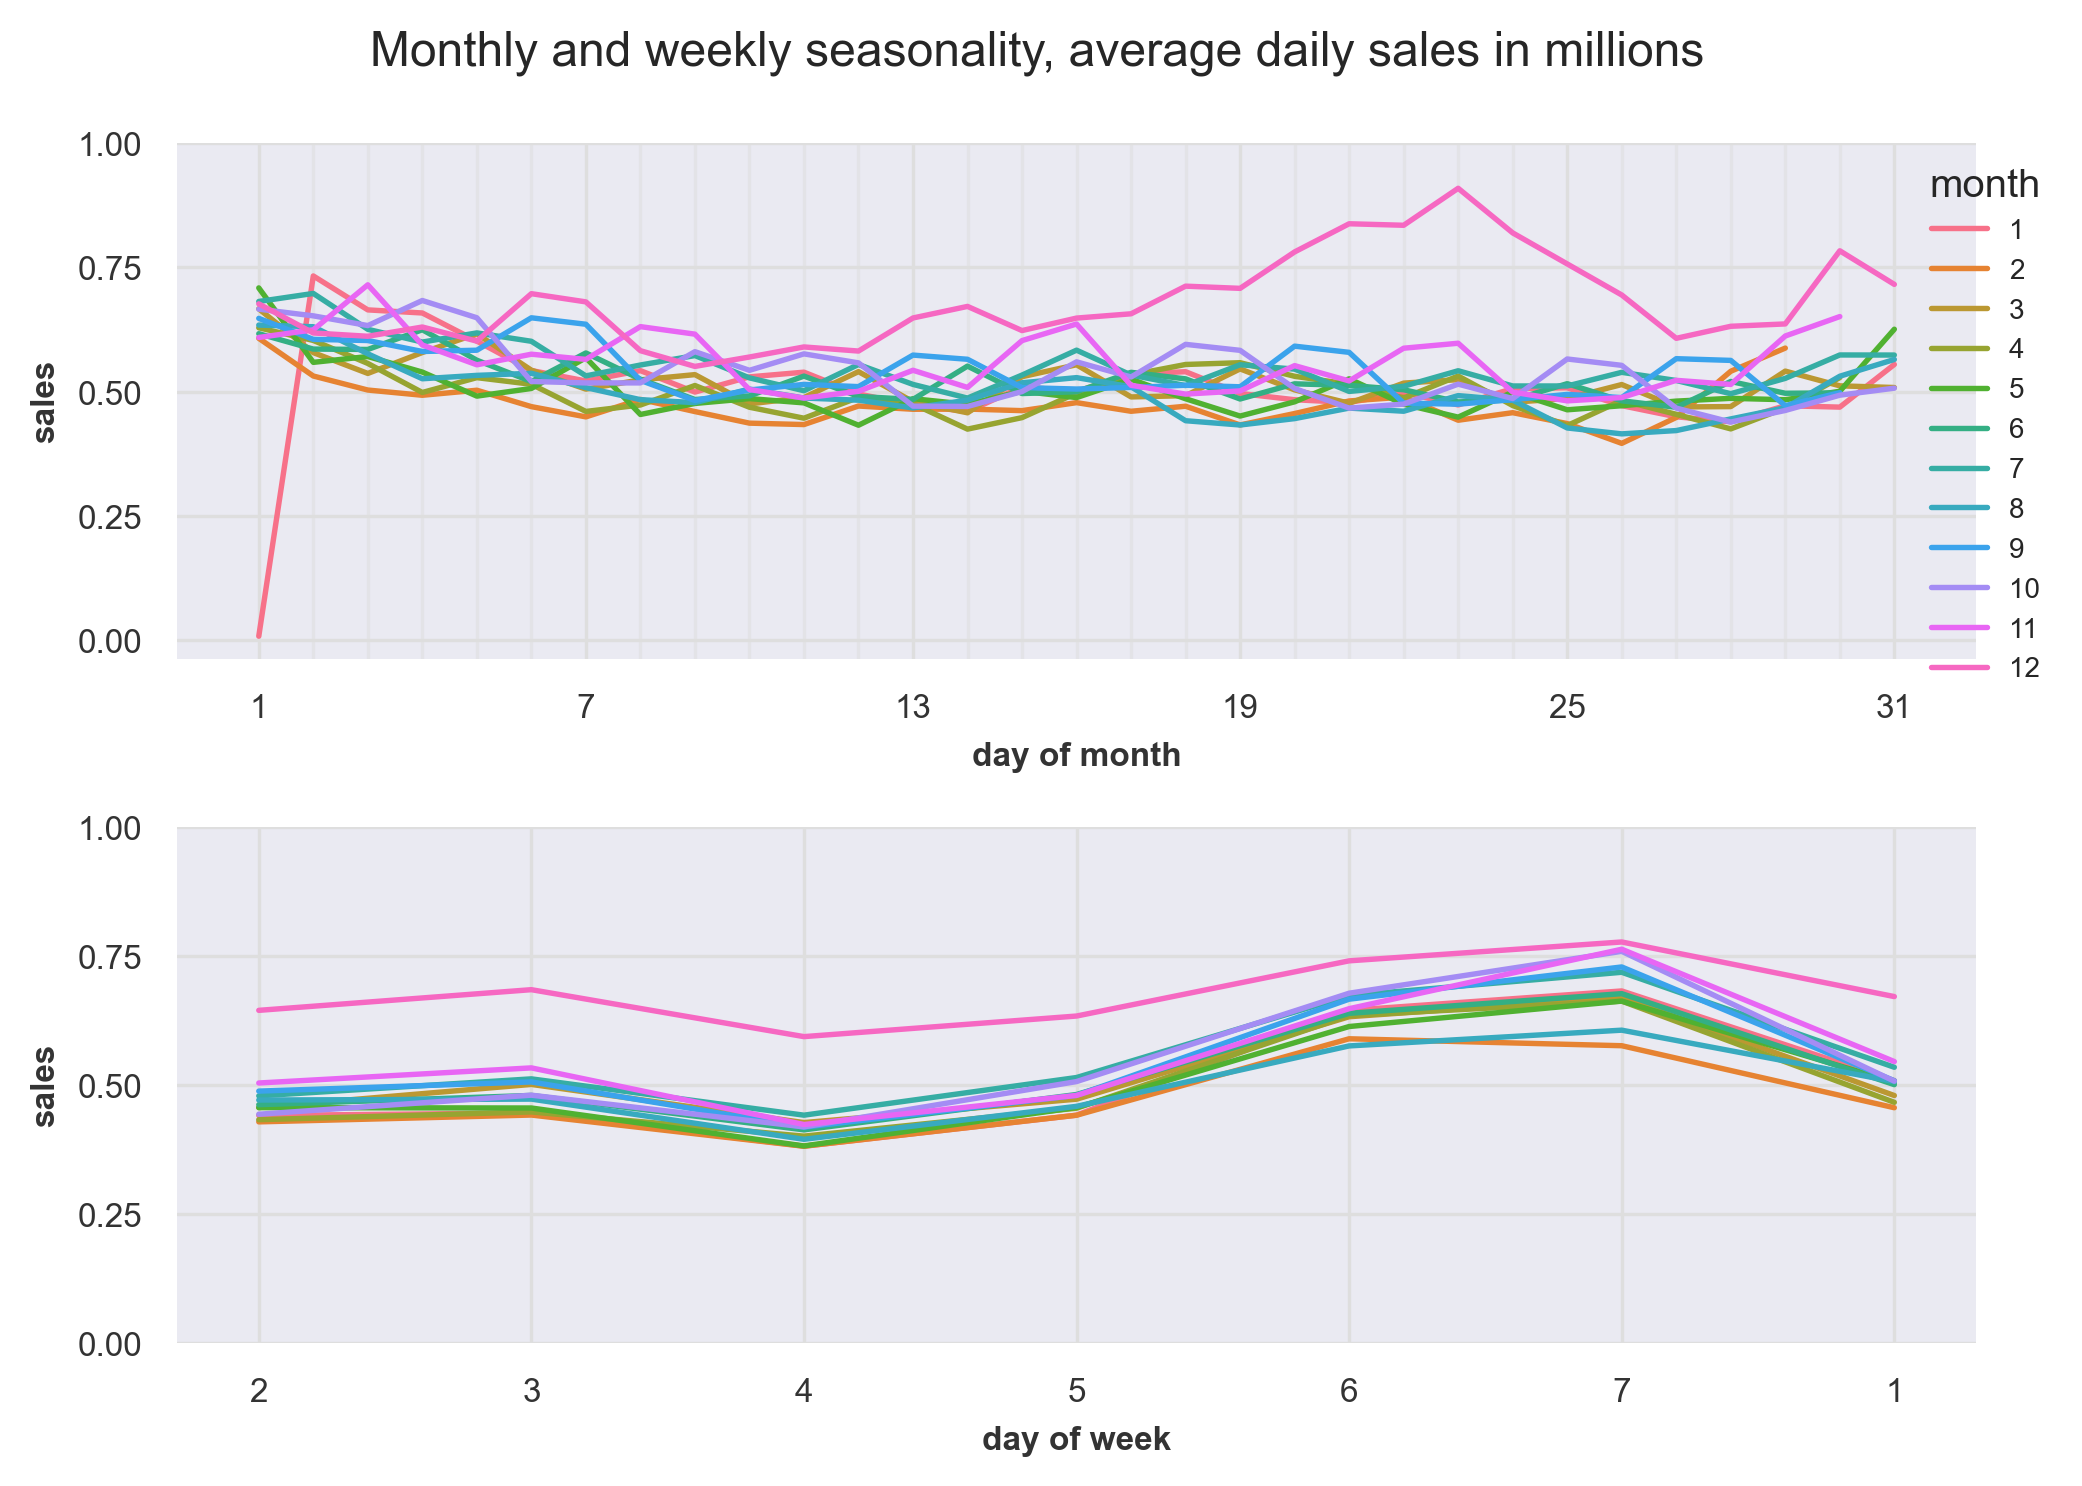

And finally, without any grouping: The averages across all years.

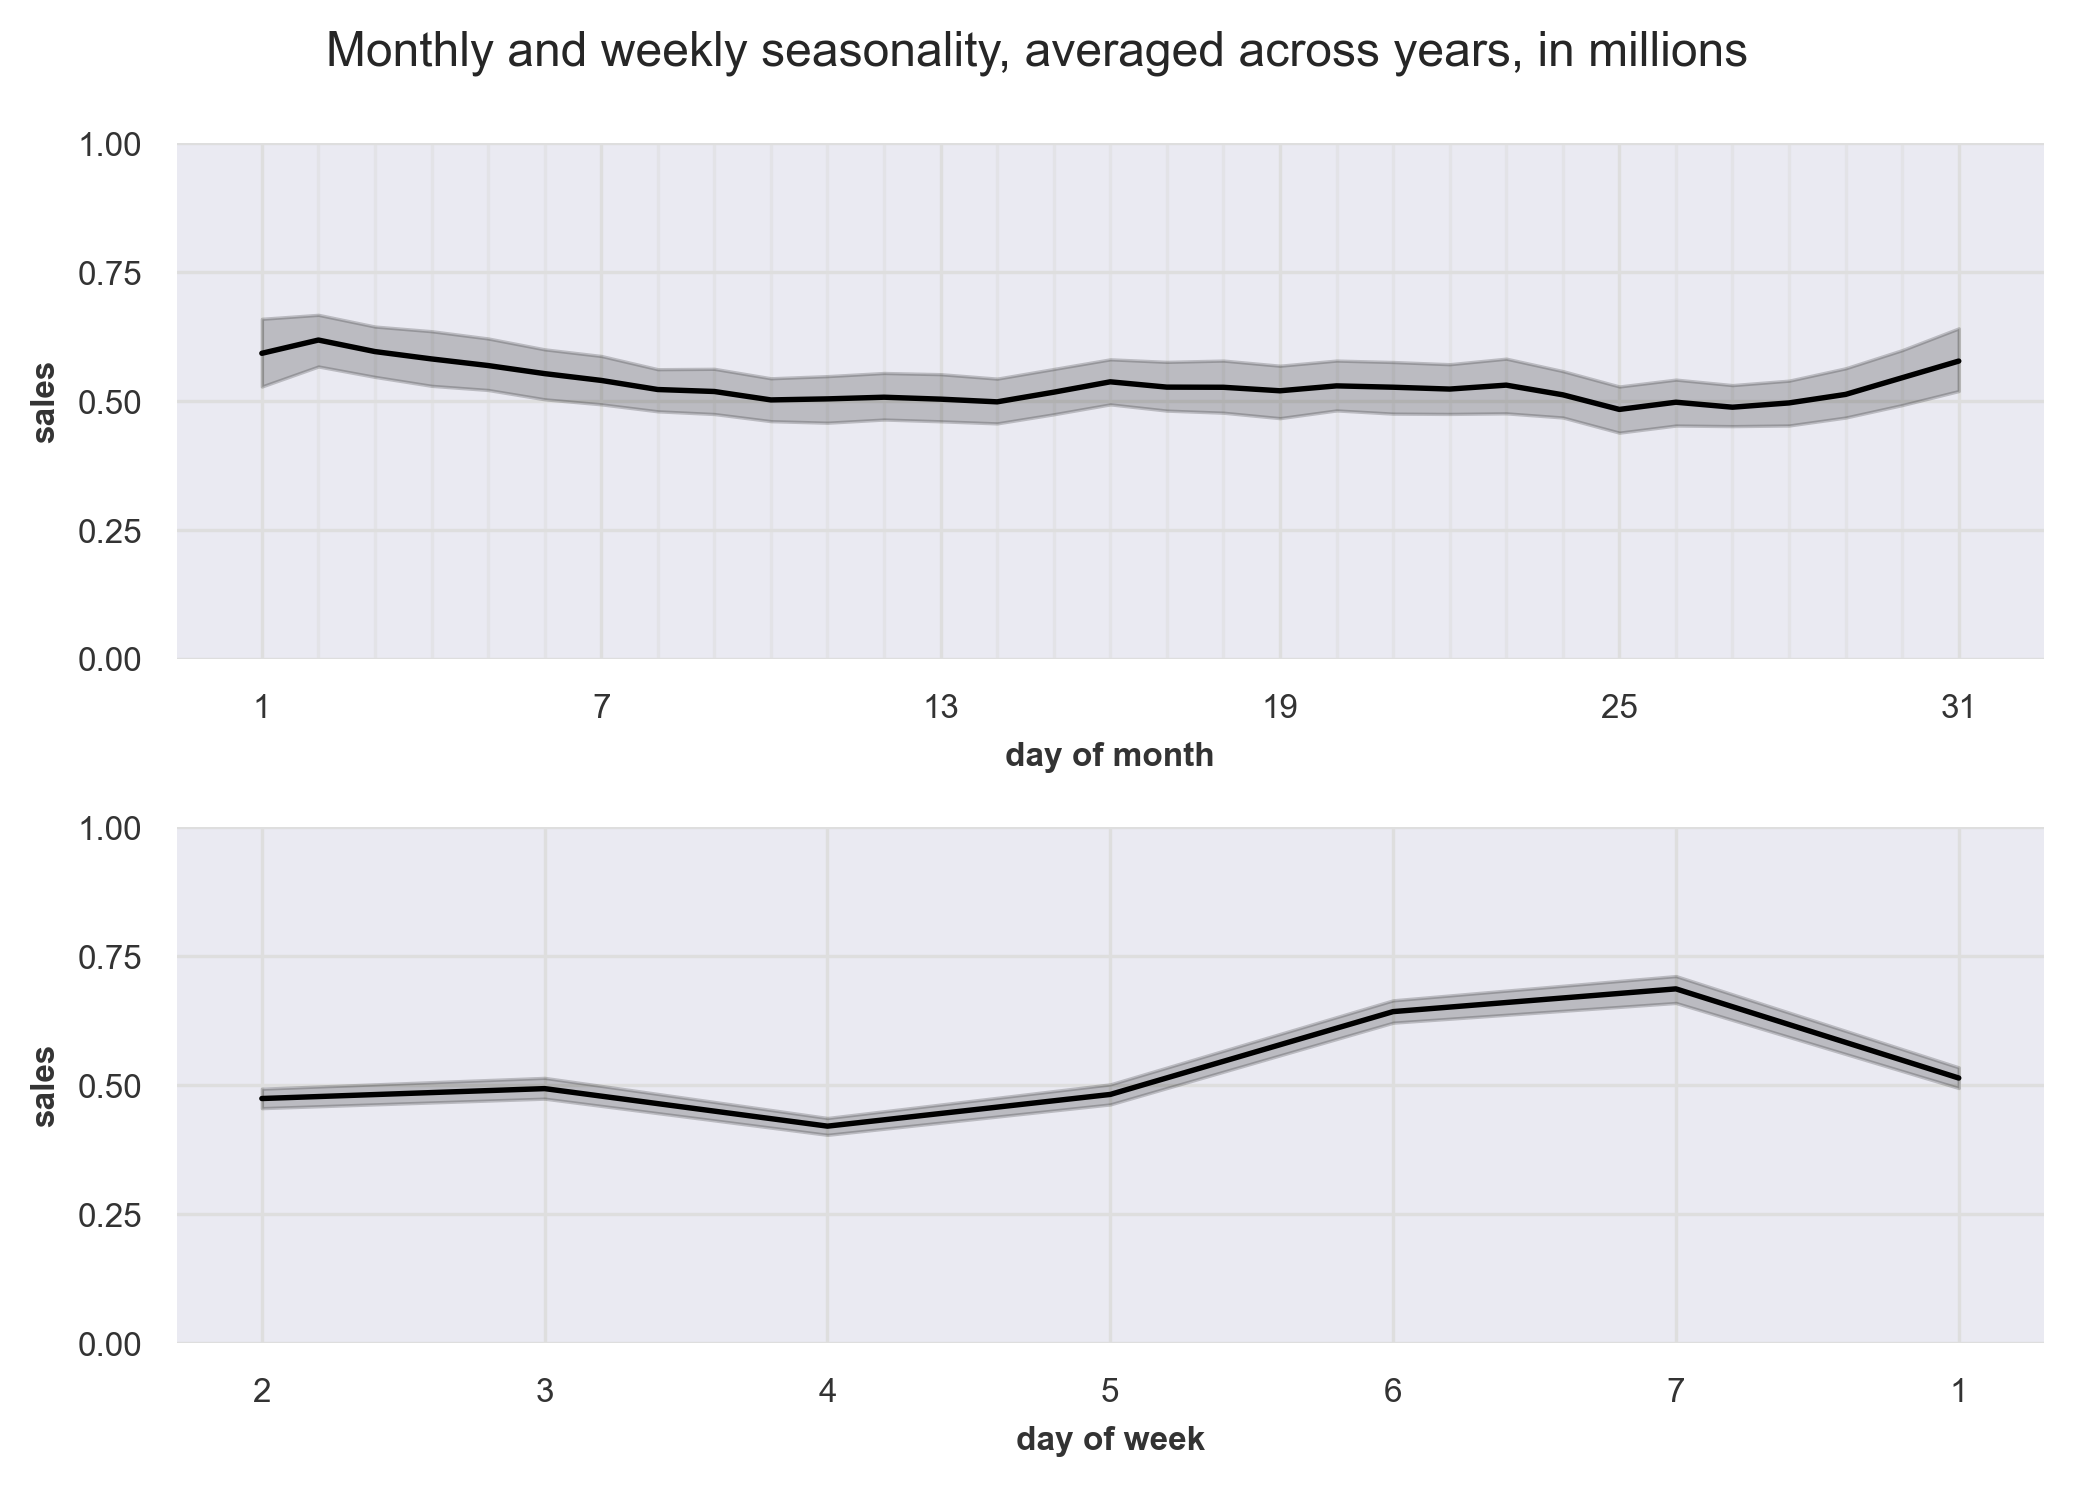

### Autocorrelation & partial autocorrelation

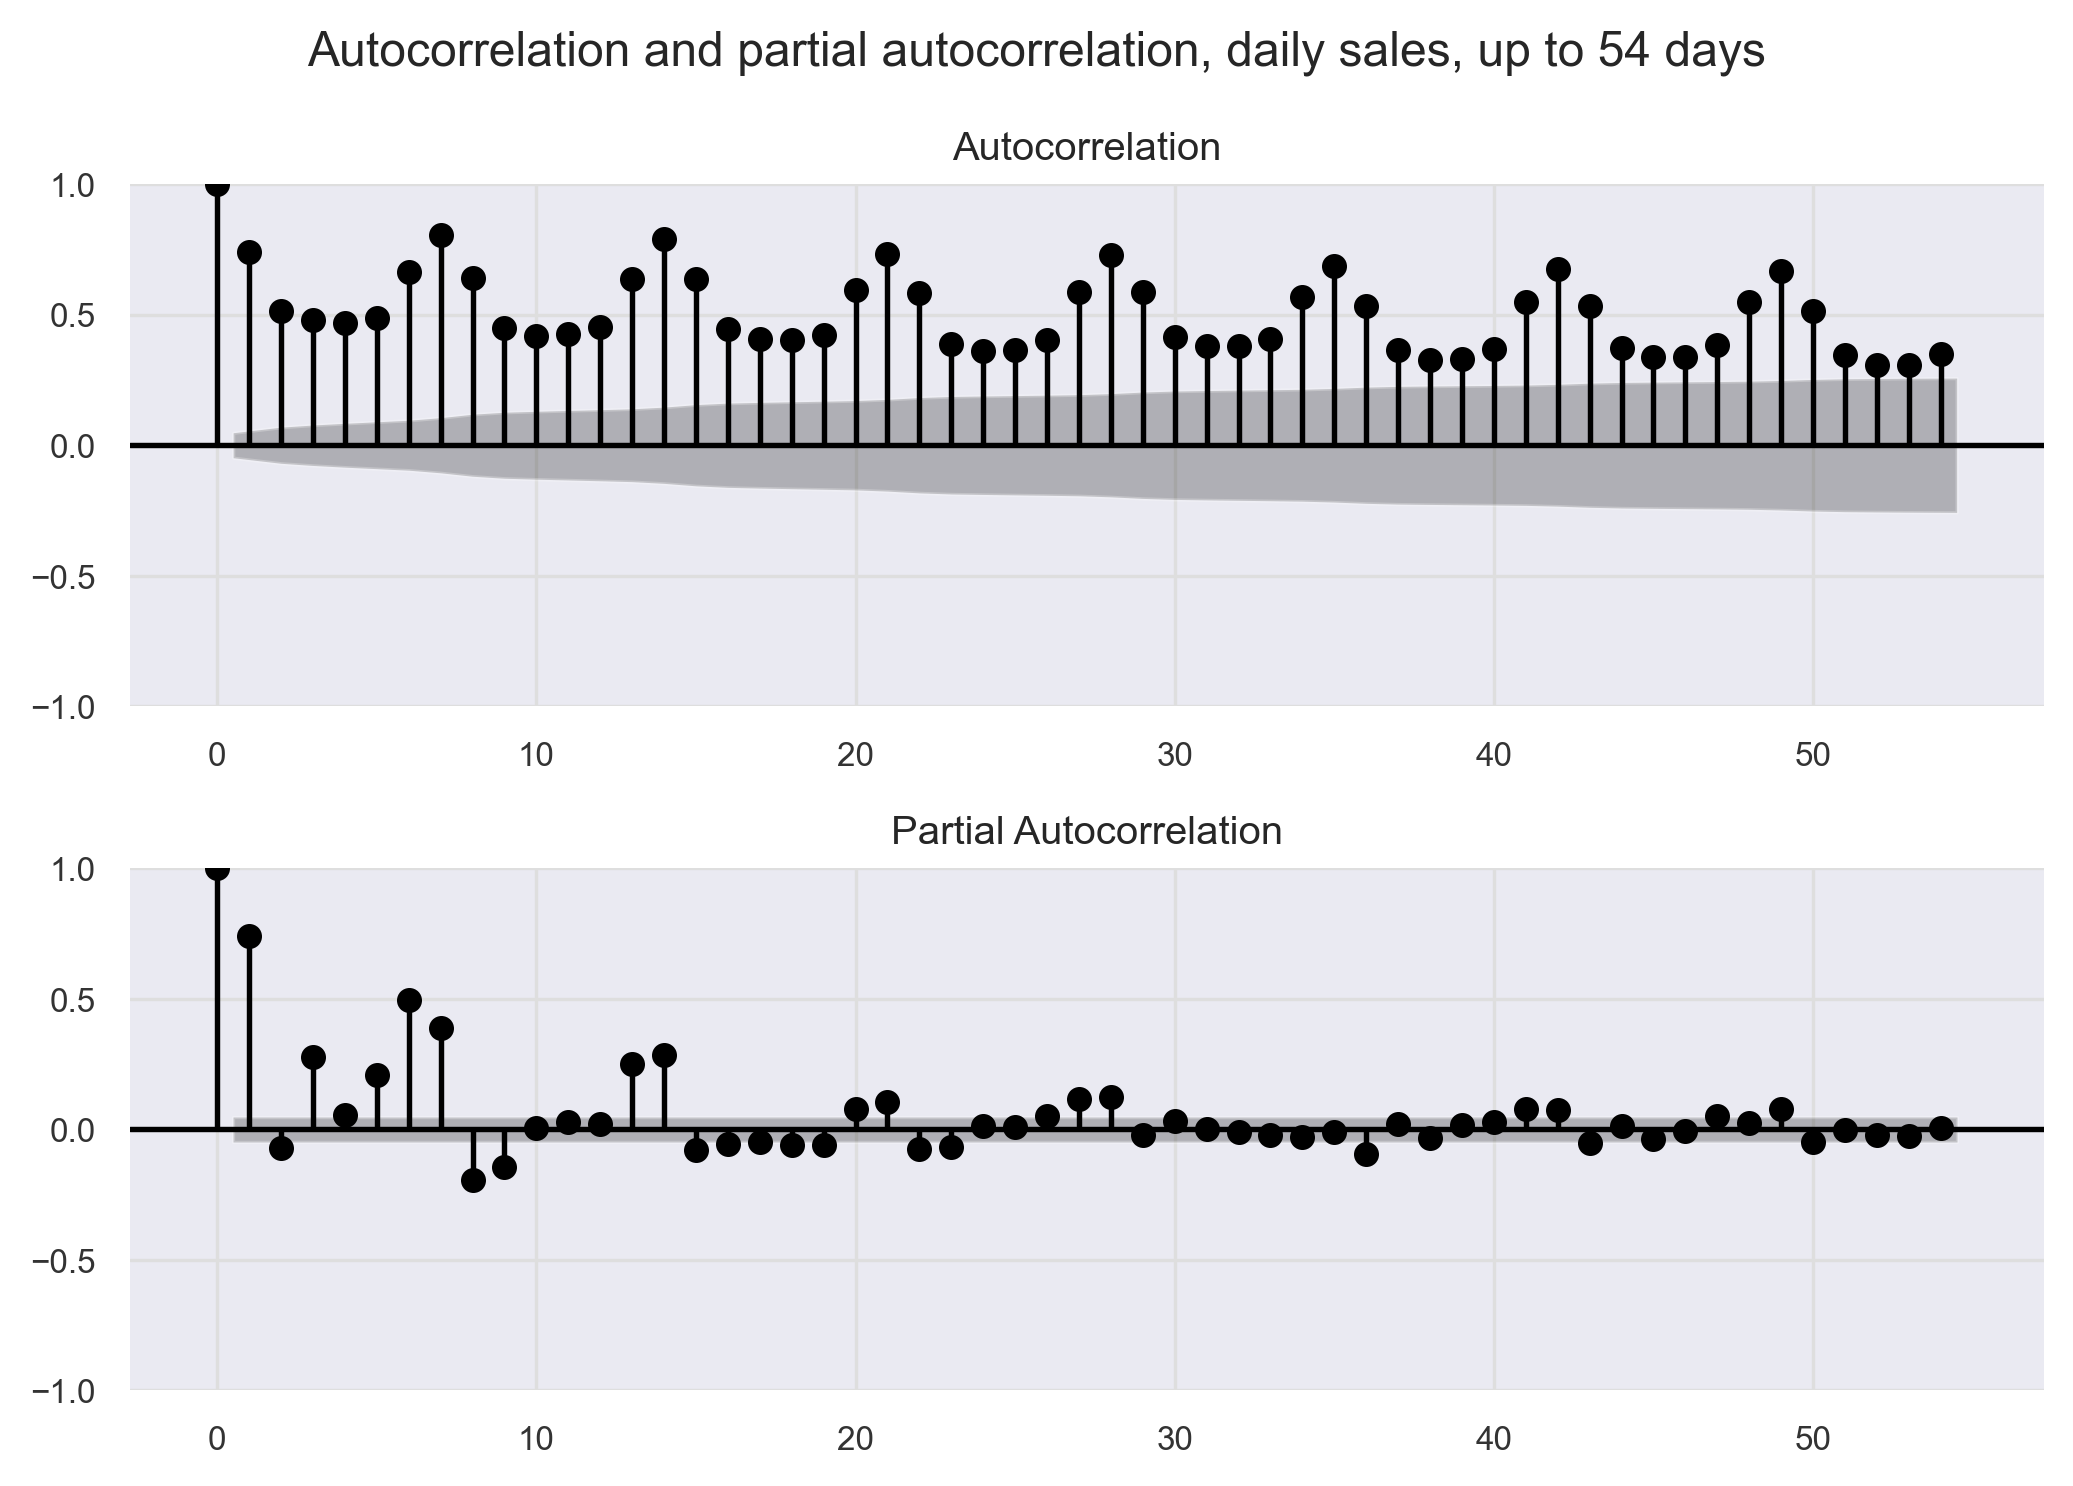

### 

## Feature engineering 1 - Time & calendar features

## Model 1 - Time effects decomposition

## Exploratory analysis 2 - Lags & covariates

## Feature engineering 2 - Lags & covariates

## Model 2 - Lags & covariates

## Conclusion